# Final Project: Wildfire Prevention
## COMPSCI 182: Artificial Intelligence
**Andrew O. Lee**

In [1]:
import os
import sys
import math
import calendar

import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.colors

import numpy as np
import pandas as pd
import sqlite3

from sklearn.ensemble import RandomForestRegressor

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature 

In [2]:
# https://www.fs.usda.gov/rds/archive/Catalog/RDS-2013-0009.4/
# http://berkeleyearth.lbl.gov/regions/california
# https://www.fire.ca.gov/incidents/

con = sqlite3.connect('data/fires.sqlite')
fire_df1 = pd.read_sql_query('SELECT * FROM Fires WHERE STATE=\'CA\' ORDER BY FIRE_YEAR', con)
fire_df2 = pd.read_csv('data/mapdataall.csv')
climate_df = pd.read_csv('data/californiaclimate.csv')

In [3]:
SHOW_TERRAIN = False # Set to True for better looking maps. Takes long time to load

MIN_ACRES = 30
LONG_MIN = -125
LONG_MAX = -114
LAT_MIN = 32
LAT_MAX = 43

avg_temps = [6.05, 8.15, 9.69, 12.36, 16.35, 20.44, 23.79, 23.15, 20.66, 15.72, 10.14, 6.48]
climate_df['avg_temp'] = climate_df['Anomaly'] + climate_df['Month'].apply(lambda x: avg_temps[x - 1])

train_df = pd.DataFrame()

train_df['year'] = fire_df1['FIRE_YEAR']
train_df['month'] = pd.DatetimeIndex(pd.to_datetime(fire_df1['DISCOVERY_DOY'], format='%j')).month
train_df['latitude'] = fire_df1['LATITUDE']
train_df['longitude'] = fire_df1['LONGITUDE']
train_df['acres'] = fire_df1['FIRE_SIZE']

train_df = train_df.merge(climate_df, left_on=['year', 'month'], right_on=['Year', 'Month'])
train_df = train_df.loc[train_df['acres'] > MIN_ACRES]
train_df = train_df.dropna()

In [4]:
X_train_ = train_df[['year', 'month', 'latitude', 'longitude', 'avg_temp']]
y_train_ = train_df[['acres']]

X_train = X_train_.to_numpy()
y_train = y_train_.to_numpy()
print(X_train.shape)
print(y_train.shape)

(7735, 5)
(7735, 1)


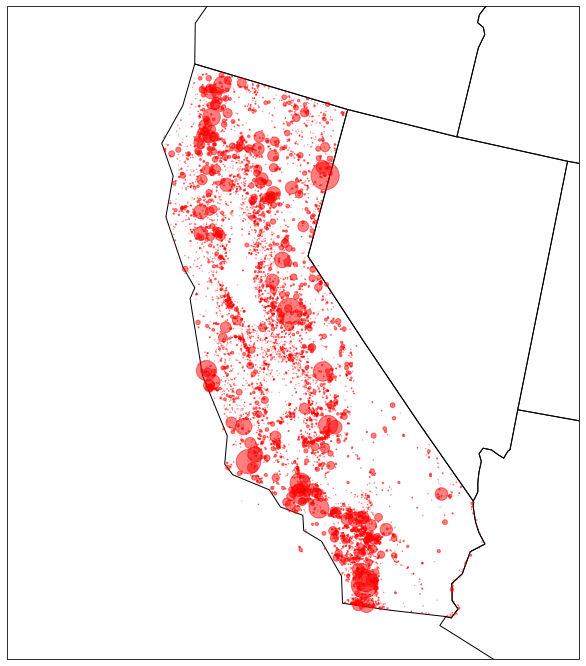

In [5]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.LambertConformal()})

ax.set_extent([LONG_MIN, LONG_MAX, LAT_MIN, LAT_MAX])
if SHOW_TERRAIN:
    ax.imshow(imread('data/NE1_50M_SR_W.jpg'), origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])

states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces_lakes_shp')

for state in shpreader.Reader(states_shp).geometries():
    ax.add_geometries([state], ccrs.PlateCarree(), edgecolor='black', facecolor='none')

ax.scatter(X_train_['longitude'], X_train_['latitude'], alpha=0.5, s=(y_train_ / 400), c='r', zorder=100, transform=ccrs.PlateCarree())
plt.show()

In [6]:
model = RandomForestRegressor().fit(X_train, np.ravel(y_train))

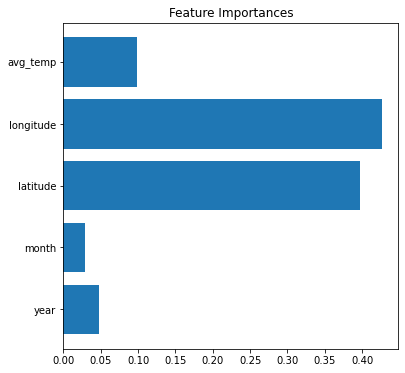

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Feature Importances")
ax.barh(X_train_.columns, model.feature_importances_)
plt.show()

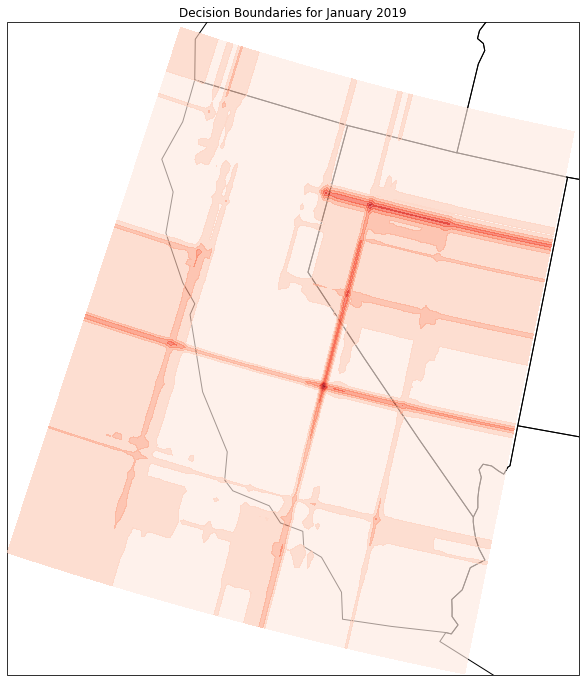

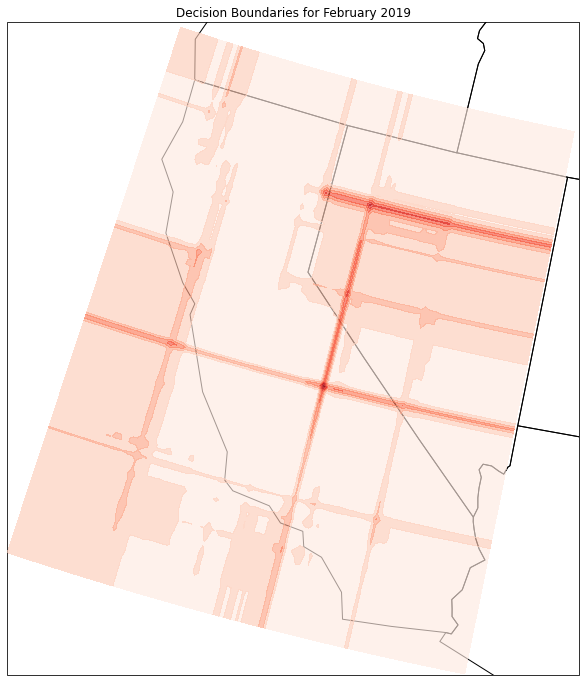

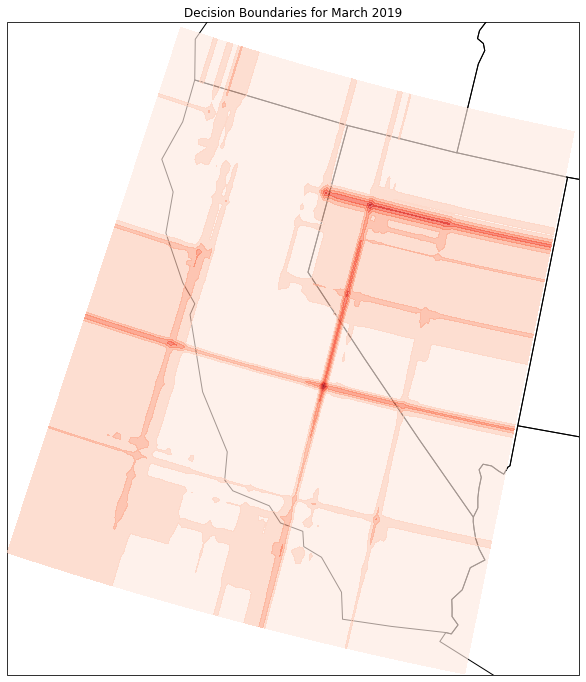

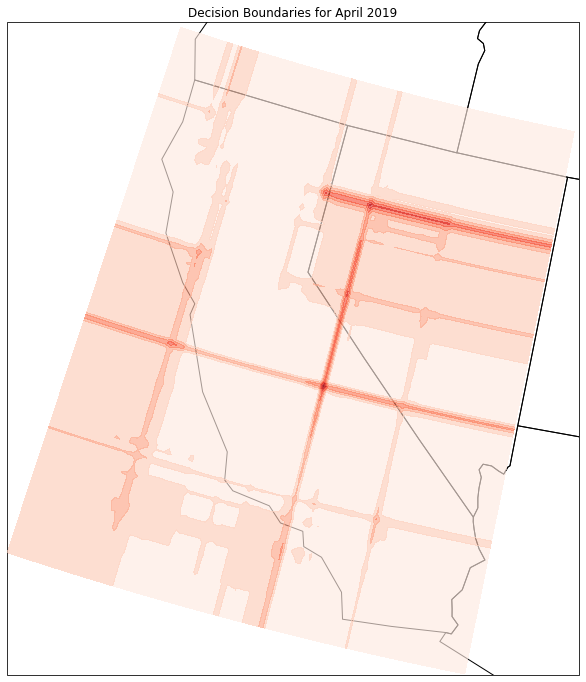

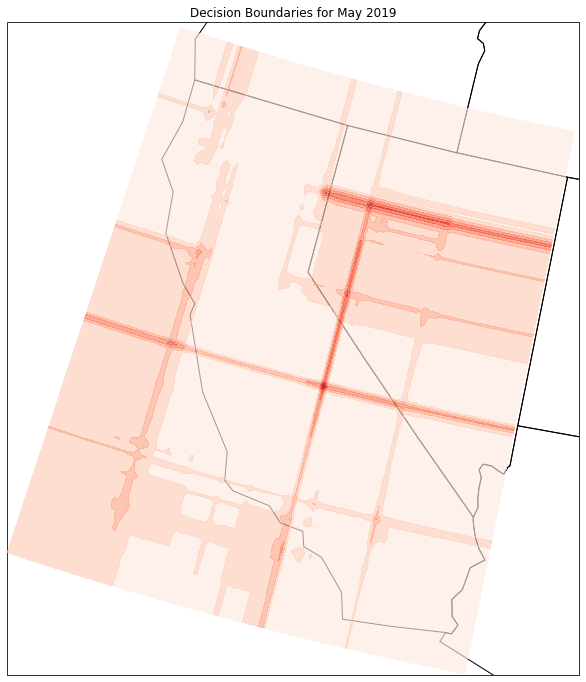

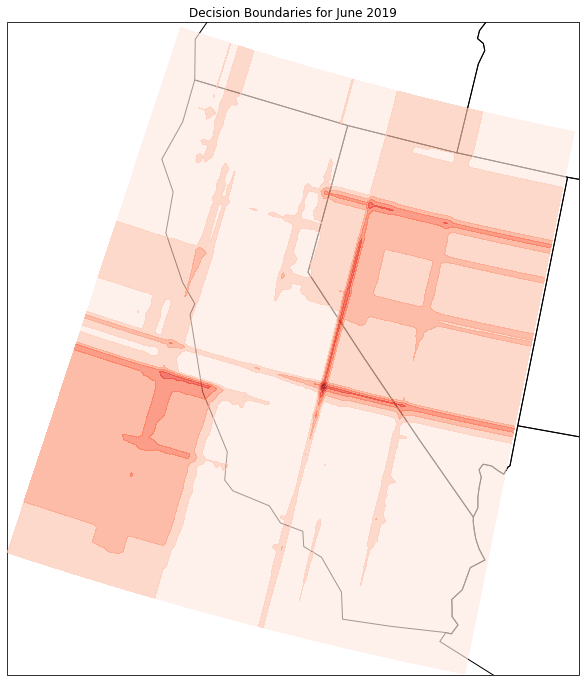

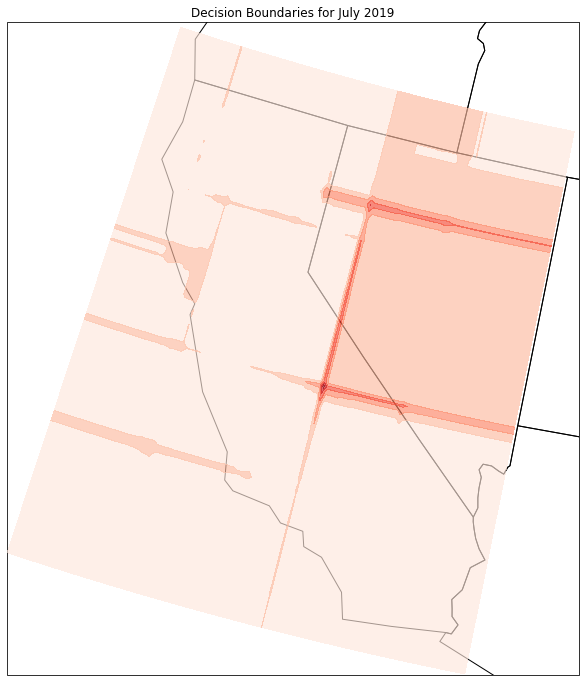

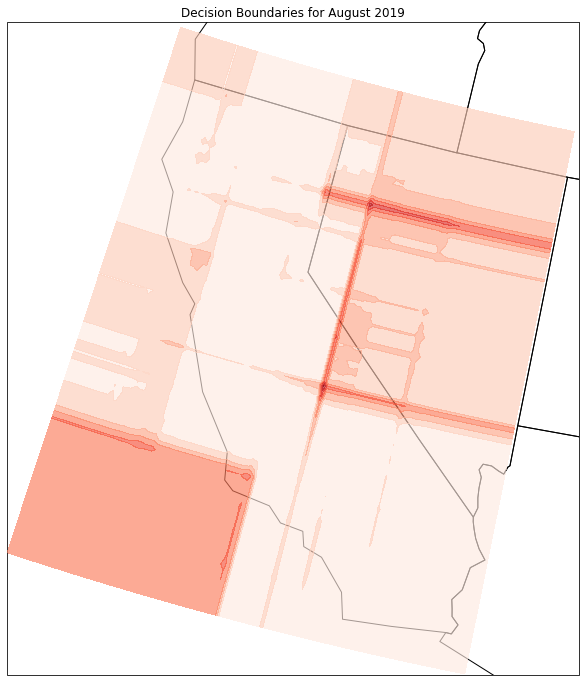

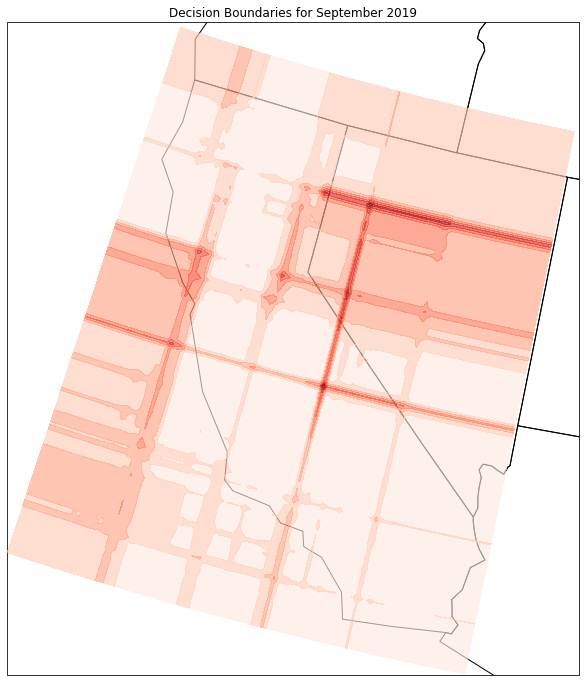

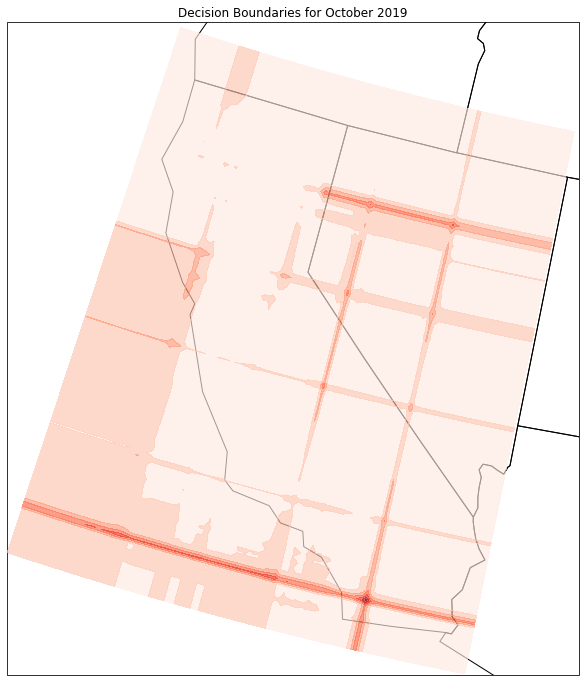

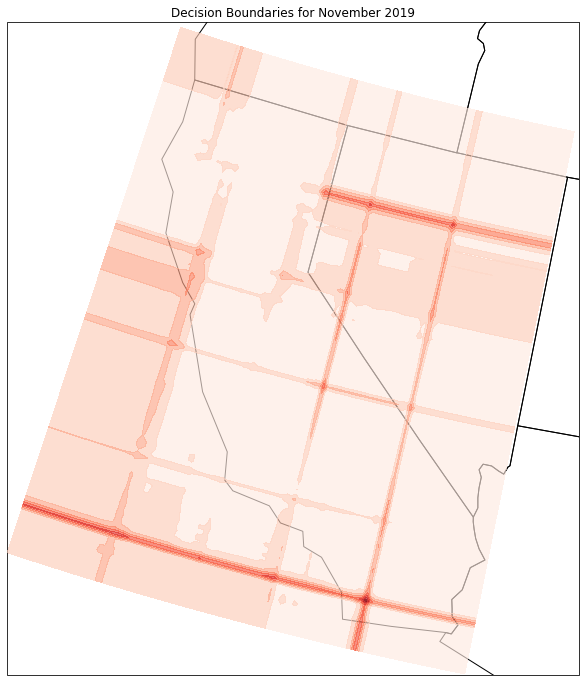

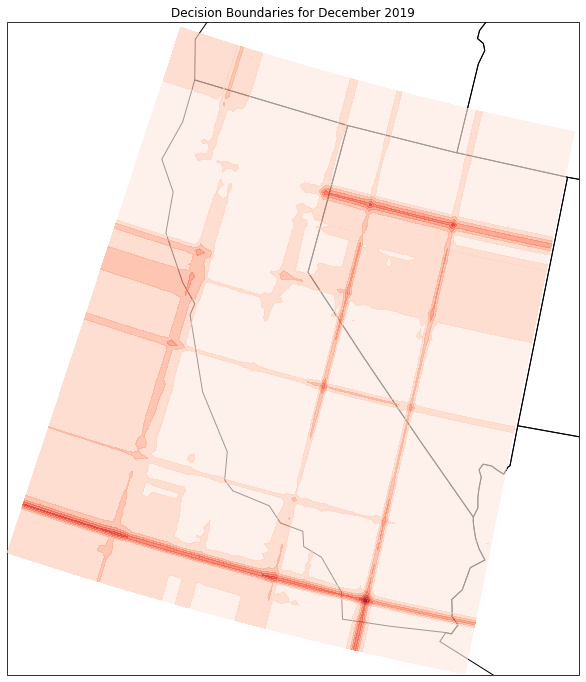

In [8]:
year = 2019

step = 0.1
long_, lat_ = np.meshgrid(np.arange(LONG_MIN, LONG_MAX, step), np.arange(LAT_MIN, LAT_MAX, step))
long = np.ravel(long_)
lat = np.ravel(lat_)

for month in range(1, 13):
    avg_temp = climate_df['avg_temp'].loc[(climate_df['Year'] == year) & (climate_df['Month'] == month)].to_numpy()[0]
    
    X_test_ = pd.DataFrame()

    X_test_['year'] = np.full(long.shape, year)
    X_test_['month'] = np.full(long.shape, month)
    X_test_['latitude'] = lat
    X_test_['longitude'] = long
    X_test_['avg_temp'] = np.full(long.shape, avg_temp)

    X_test = X_test_.to_numpy()

    y_hat = model.predict(X_test)

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.LambertConformal()})

    ax.set_extent([LONG_MIN, LONG_MAX, LAT_MIN, LAT_MAX])
    if SHOW_TERRAIN:
        ax.imshow(imread('data/NE1_50M_SR_W.jpg'), origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])

    states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces_lakes_shp')

    for state in shpreader.Reader(states_shp).geometries():
        ax.add_geometries([state], ccrs.PlateCarree(), edgecolor='black', facecolor='none')

    cmap = plt.get_cmap('Reds')
    cmap = np.array([list(cmap(i)) for i in range(cmap.N)])
    cmap[:,-1] = np.full(cmap[:,-1].shape, 0.65)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmap, len(cmap))
    ax.contourf(long_, lat_, np.reshape(y_hat, long_.shape), zorder=100, cmap=cmap, transform=ccrs.PlateCarree())
    ax.set_title(f"Decision Boundaries for {calendar.month_name[month]} {year}")
    plt.show()

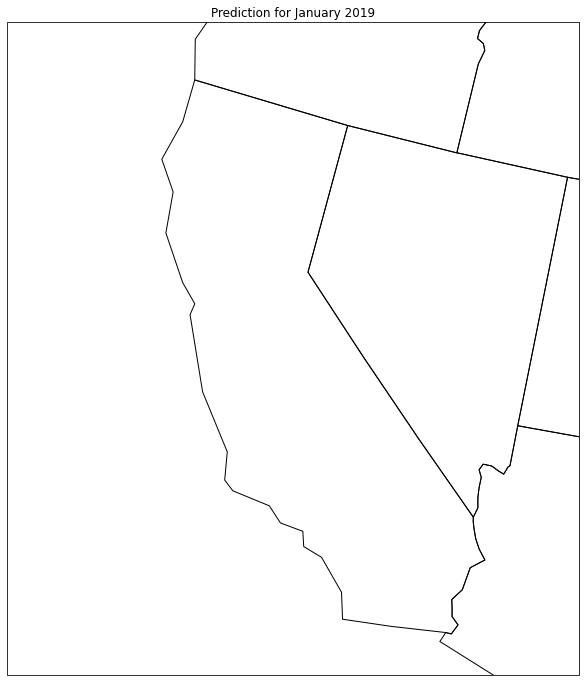

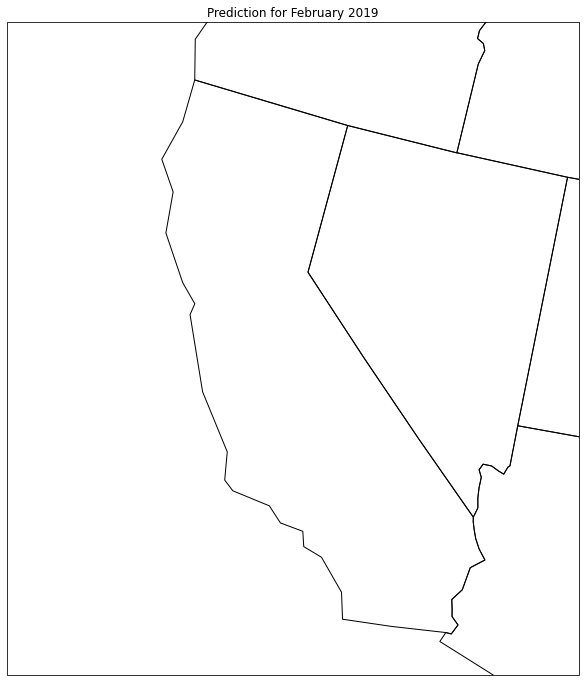

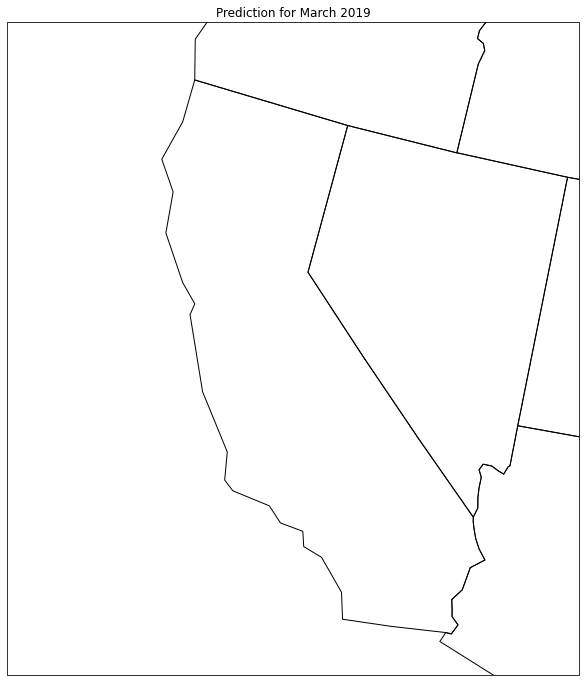

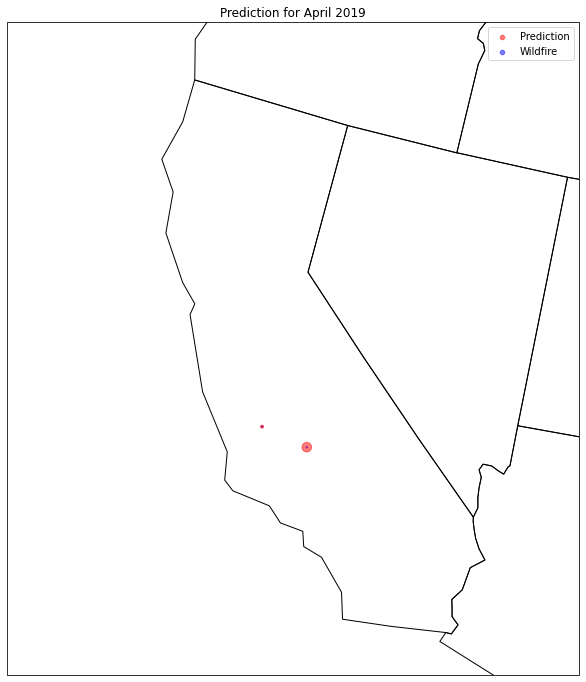

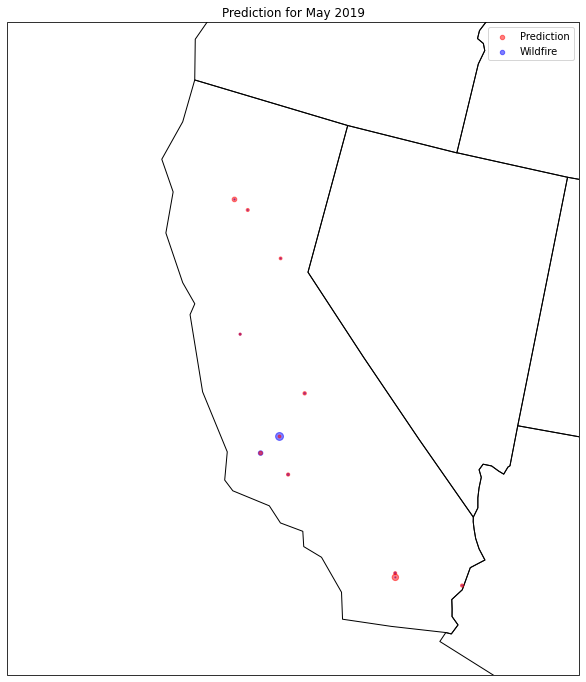

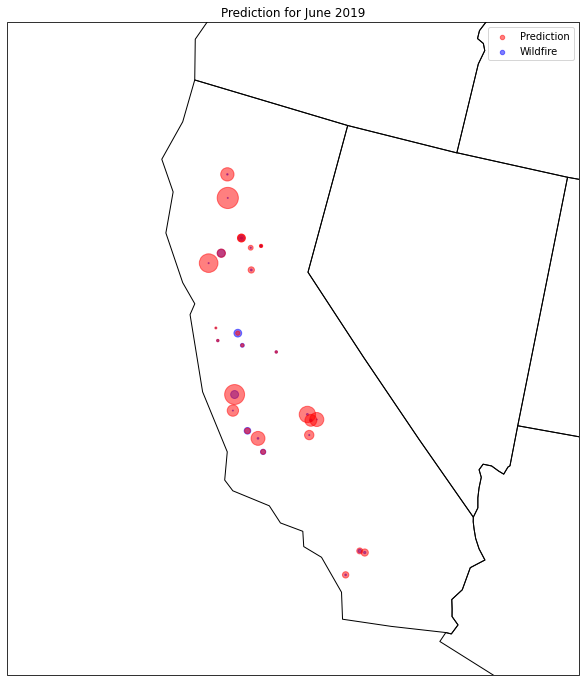

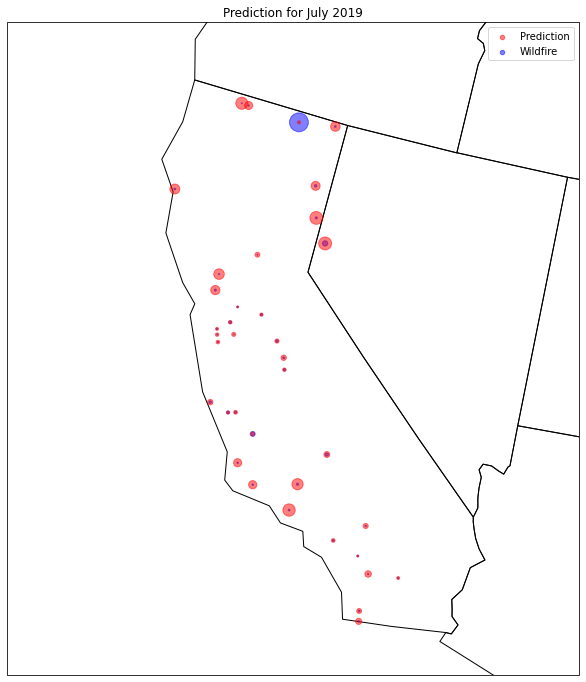

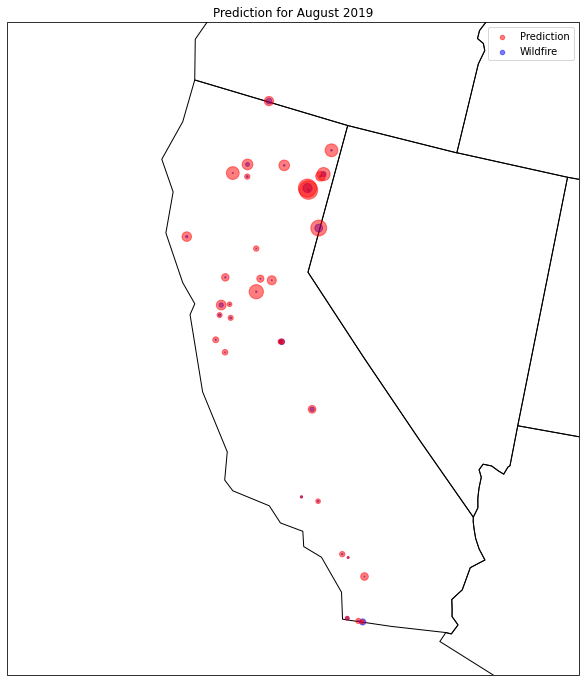

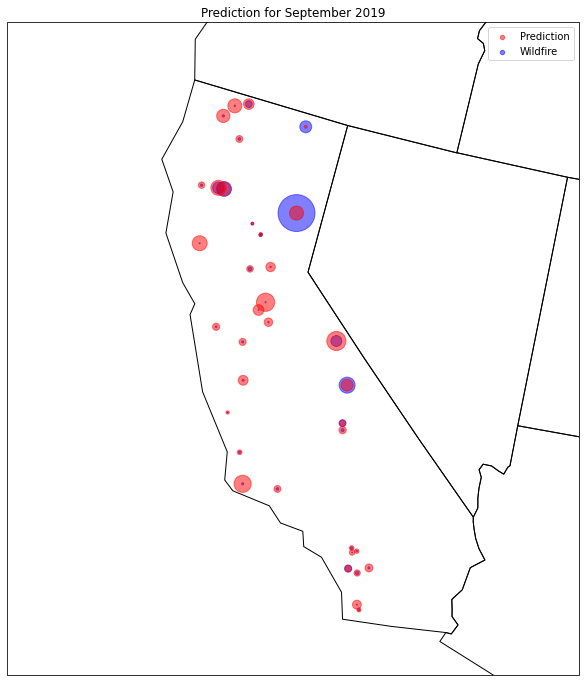

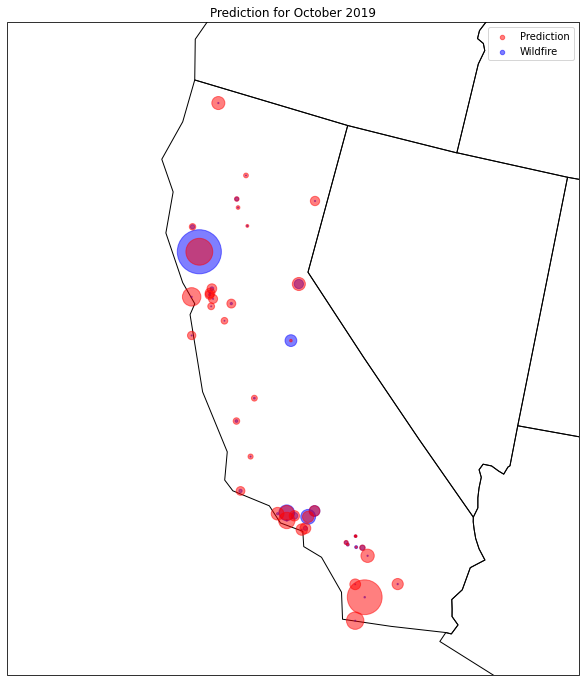

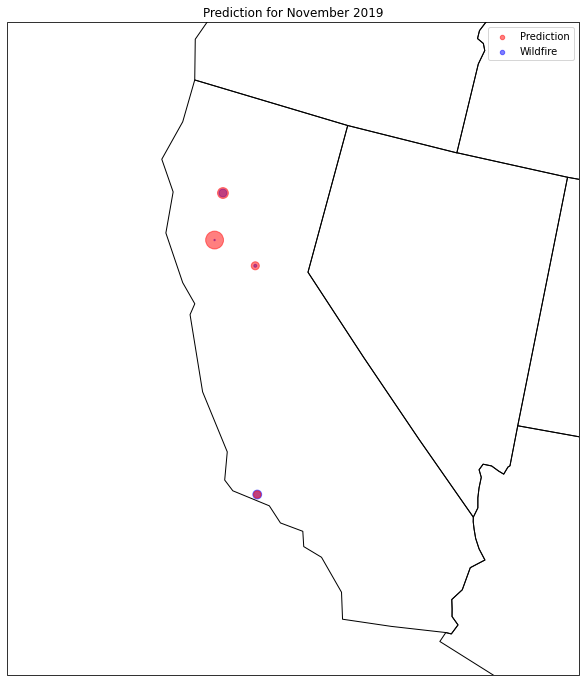

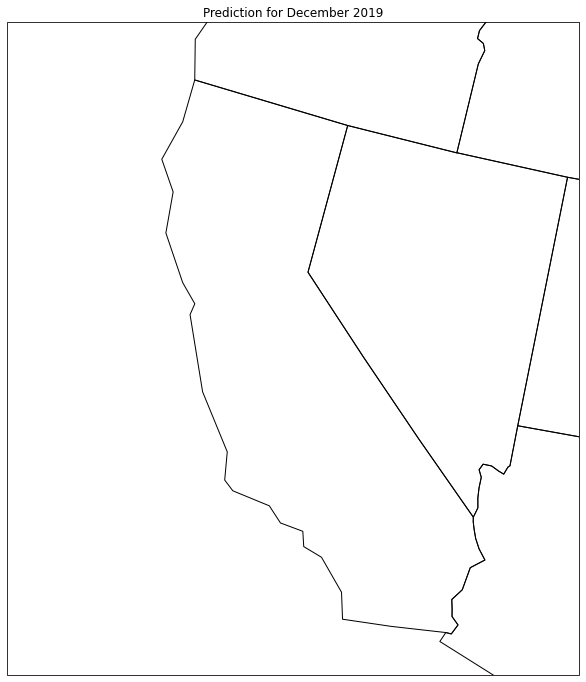

In [9]:
test_df = pd.DataFrame()

test_df['year'] = pd.DatetimeIndex(fire_df2['incident_dateonly_created']).year
test_df['month'] = pd.DatetimeIndex(fire_df2['incident_dateonly_created']).month
test_df['latitude'] = fire_df2['incident_latitude']
test_df['longitude'] = fire_df2['incident_longitude']
test_df['acres'] = fire_df2['incident_acres_burned']

test_df = test_df.merge(climate_df, left_on=['year', 'month'], right_on=['Year', 'Month'])
test_df = test_df.loc[test_df['acres'] > MIN_ACRES]
test_df = test_df.loc[(test_df['longitude'] > LONG_MIN) & (test_df['longitude'] < LONG_MAX)]
test_df = test_df.loc[(test_df['latitude'] > LAT_MIN) & (test_df['latitude'] < LAT_MAX)]
test_df = test_df.dropna()

for month in range(1, 13):
    X_test_ = test_df[['year', 'month', 'latitude', 'longitude', 'avg_temp']].loc[(test_df['month'] == month) & (test_df['year'] == year)]
    y_test_ = test_df[['acres']].loc[(test_df['month'] == month) & (test_df['year'] == year)]

    X_test = X_test_.to_numpy()
    y_test = y_test_.to_numpy()

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.LambertConformal()})

    ax.set_extent([LONG_MIN, LONG_MAX, LAT_MIN, LAT_MAX])
    if SHOW_TERRAIN:
        ax.imshow(imread('data/NE1_50M_SR_W.jpg'), origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])

    states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces_lakes_shp')

    for state in shpreader.Reader(states_shp).geometries():
        ax.add_geometries([state], ccrs.PlateCarree(), edgecolor='black', facecolor='none')
        
    if X_test.shape[0] > 0:
        y_hat = model.predict(X_test)
        ax.scatter(X_test_['longitude'], X_test_['latitude'], alpha=0.5, s=(y_hat / 40), c='r', zorder=100, transform=ccrs.PlateCarree(), label='Prediction')
        ax.scatter(X_test_['longitude'], X_test_['latitude'], alpha=0.5, s=(y_test_ / 40), c='b', zorder=99, transform=ccrs.PlateCarree(), label='Wildfire')
        legend = ax.legend()
        for handle in legend.legendHandles:
            handle.set_sizes([20])
    ax.set_title(f"Prediction for {calendar.month_name[month]} {year}")
    plt.show()

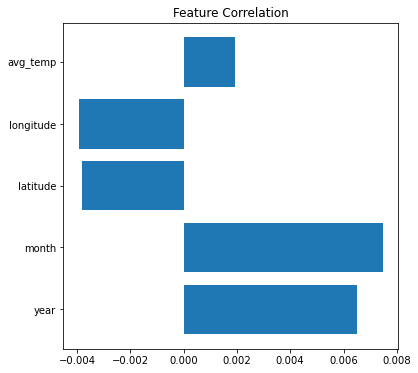

In [10]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Feature Correlation")

X_train_scaled = (X_train_ - X_train_.min()) / (X_train_.max() - X_train_.min())
y_train_scaled = (y_train_ - y_train_.min()) / (y_train.max() - y_train_.min())
linreg = LinearRegression(fit_intercept=False).fit(X_train_scaled, np.ravel(y_train_scaled.to_numpy()))

ax.barh(X_train_.columns, linreg.coef_)
plt.show()